In [137]:
#imports

from itertools import product
import operator

import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import altair as alt
alt.renderers.enable("notebook")

RendererRegistry.enable('notebook')

In [184]:
#global vars
NUM_QUANTILES = 20

In [43]:
#get dataset
dataBunch = datasets.load_breast_cancer(return_X_y=False)
data_to_use = {"data": dataBunch.data[:,:10],
               "target": dataBunch.target,
               "feature_names": dataBunch.feature_names[:10],
               "feature_locs": {x:i for i,x in enumerate(dataBunch.feature_names[:10])}
              } #make it easy to change out data

In [44]:
#build classifier to explain
classifier = RandomForestClassifier(n_estimators=200, max_depth=2)
classifier.fit(data_to_use["data"], data_to_use["target"])
predictions = classifier.predict(data_to_use["data"])
print accuracy_score(data_to_use["target"], predictions)

0.9420035149384886


In [185]:
#generate data structure for pairwise charts
feature_pairs = {key: {"map":None, "predicates":[]}\
                 for key in set([tuple(sorted(t)) for t in product(data_to_use["feature_names"], repeat=2)])}
for key in feature_pairs.iterkeys():
    x_loc = data_to_use["feature_locs"][key[0]]
    y_loc = data_to_use["feature_locs"][key[1]]
    x_quantiles = np.unique(np.quantile(a=data_to_use["data"][x_loc], q=np.linspace(0, 1, NUM_QUANTILES)))
    y_quantiles = np.unique(np.quantile(a=data_to_use["data"][y_loc], q=np.linspace(0, 1, NUM_QUANTILES)))
    #y_quantiles = data_to_use["data"][y_loc].quantile(np.linspace(0, 1, NUM_QUANTILES)).unique()
    def get_quantile_tuple(x,y):
        return {data_to_use["feature_names"][x_loc]: round(x_quantiles[int(x)],2),\
                data_to_use["feature_names"][y_loc]: round(y_quantiles[int(y)],2)}
    feature_pairs[key]["map"] = np.fromfunction(np.vectorize(get_quantile_tuple),\
                                                shape=(NUM_QUANTILES, NUM_QUANTILES))
for model in classifier.estimators_:
    feature_ids = {i:{"number":x, "name":data_to_use["feature_names"][x]}\
                      for i,x in enumerate(list(model.tree_.feature)) if x>=0} #-2 means leaf node
    for node_position in [1,4]: #positions for left and right nodes at layer 2
        feature_pair_key = tuple(sorted([feature_ids[0]["name"], feature_ids[node_position]["name"]]))
        #get the decision rules
        decision_func_dict = {
            "feature_name_1": feature_ids[0]["name"],
            "threshold_1": model.tree_.threshold[0],
            
            "operator_1": operator.le if node_position == 1 else operator.gt,
            
            "feature_name_2": feature_ids[node_position]["name"],
            "threshold_2": model.tree_.threshold[node_position],
            
            "operator_2": operator.le,
            
            "prob_le": model.tree_.value[node_position+1][0][1]/\
            (model.tree_.value[node_position+1][0][1] + model.tree_.value[node_position+1][0][0]),
            
            "prob_gt": model.tree_.value[node_position+2][0][1]/\
            (model.tree_.value[node_position+2][0][1] + model.tree_.value[node_position+2][0][0])
        }
        #build the predictive function used in the decision tree
        def dt_predicate(data_case, decision_func_dict=decision_func_dict):
            if decision_func_dict["operator_1"](\
                                                data_case[decision_func_dict["feature_name_1"]],\
                                                decision_func_dict["threshold_1"]\
                                               ):
                if decision_func_dict["operator_2"](\
                                                    data_case[decision_func_dict["feature_name_2"]],\
                                                    decision_func_dict["threshold_2"]\
                                                   ):
                    return decision_func_dict["prob_le"]
                else:
                    return decision_func_dict["prob_gt"]
            else:
                return 0.

        feature_pairs[feature_pair_key]["predicates"].append(dt_predicate)

In [186]:
#now calculate output array for each feature pair
for key, value in feature_pairs.iteritems():
    arrs = []
    for predicate in value["predicates"]:
        f = np.vectorize(predicate)
        arrs.append(f(value["map"]))
    if len(arrs) > 0:
        #details of vote aggreggation method for random forest
        #https://stats.stackexchange.com/questions/127077/random-forest-probabilistic-prediction-vs-majority-vote
        value["output"] = np.sum(np.stack(arrs, axis=-1), axis=-1)
    else:
        value["output"] = None

In [187]:
vis_df_dict = {}
for key, value in feature_pairs.iteritems():
    x = key[0]
    y = key[1]
    if x+"_H" not in vis_df_dict:
        vis_df_dict[x+"_H"] = [p[x] for p in list(value["map"].ravel())]
    if y+"_V" not in vis_df_dict:
        vis_df_dict[y+"_V"] = [p[y] for p in list(value["map"].ravel())]
    vis_df_dict[x+"+"+y] = list(value["output"].ravel()) if value["output"] is not None else None

In [188]:
chart_data = pd.DataFrame(vis_df_dict)
chart_data.head()

,mean area+mean area,mean area+mean compactness,mean area+mean concave points,mean area+mean concavity,mean area+mean fractal dimension,mean area+mean perimeter,mean area+mean radius,mean area+mean smoothness,mean area+mean symmetry,mean area+mean texture,...,mean smoothness+mean texture,mean smoothness_H,mean smoothness_V,mean symmetry+mean symmetry,mean symmetry+mean texture,mean symmetry_H,mean symmetry_V,mean texture+mean texture,mean texture_H,mean texture_V
0,0.0,7.718505,12.655778,16.268093,1.198242,3.80263,1.94175,4.658910,1.841759,0.947791,...,None,0.06,0.06,None,None,0.07,0.07,None,0.06,0.06
1,0.0,7.718505,12.655778,16.268093,1.198242,3.80263,1.94175,4.658910,1.841759,0.947791,...,None,0.06,0.08,None,None,0.08,0.08,None,0.06,0.06
2,0.0,7.718505,12.655778,16.268093,1.198242,3.80263,1.94175,3.695811,1.841759,0.947791,...,None,0.06,0.10,None,None,0.09,0.09,None,0.07,0.07
3,0.0,8.498993,12.655778,16.268093,1.198242,3.80263,1.94175,3.695811,1.841759,0.947791,...,None,0.06,0.10,None,None,0.11,0.11,None,0.07,0.07
4,0.0,7.211636,12.655778,15.750299,1.198242,3.80263,1.94175,3.695811,1.841759,0.947791,...,None,0.06,0.10,None,None,0.12,0.12,None,0.08,0.08


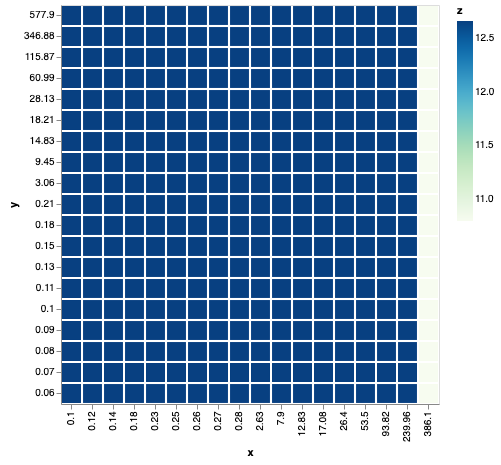

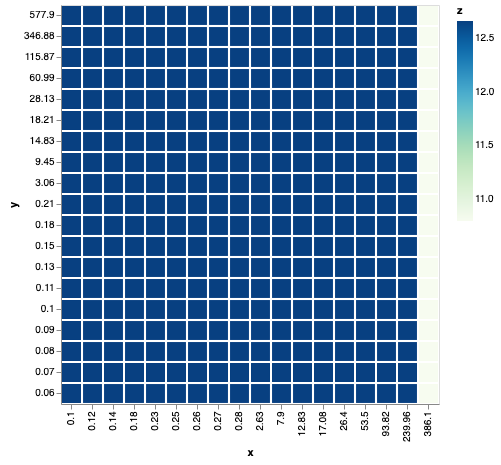

In [189]:
feature_1 = 'mean area'
feature_2 = 'mean concave points'

x = [p[feature_1] for p in list(feature_pairs[(feature_1, feature_2)]["map"].ravel())]
y = [p[feature_2] for p in list(feature_pairs[(feature_1, feature_2)]["map"].ravel())]
z = list(feature_pairs[(feature_1, feature_2)]["output"].ravel())

sample_chart_data = pd.DataFrame({'x': x,
                                  'y': y,
                                  'z': z})

alt.Chart(sample_chart_data).mark_rect().encode(
    x='x:O',
    y=alt.Y(field="y", type="ordinal", sort="descending"),
    color=alt.Color(field="z", type="quantitative", scale=alt.Scale(scheme='greenblue'))
)

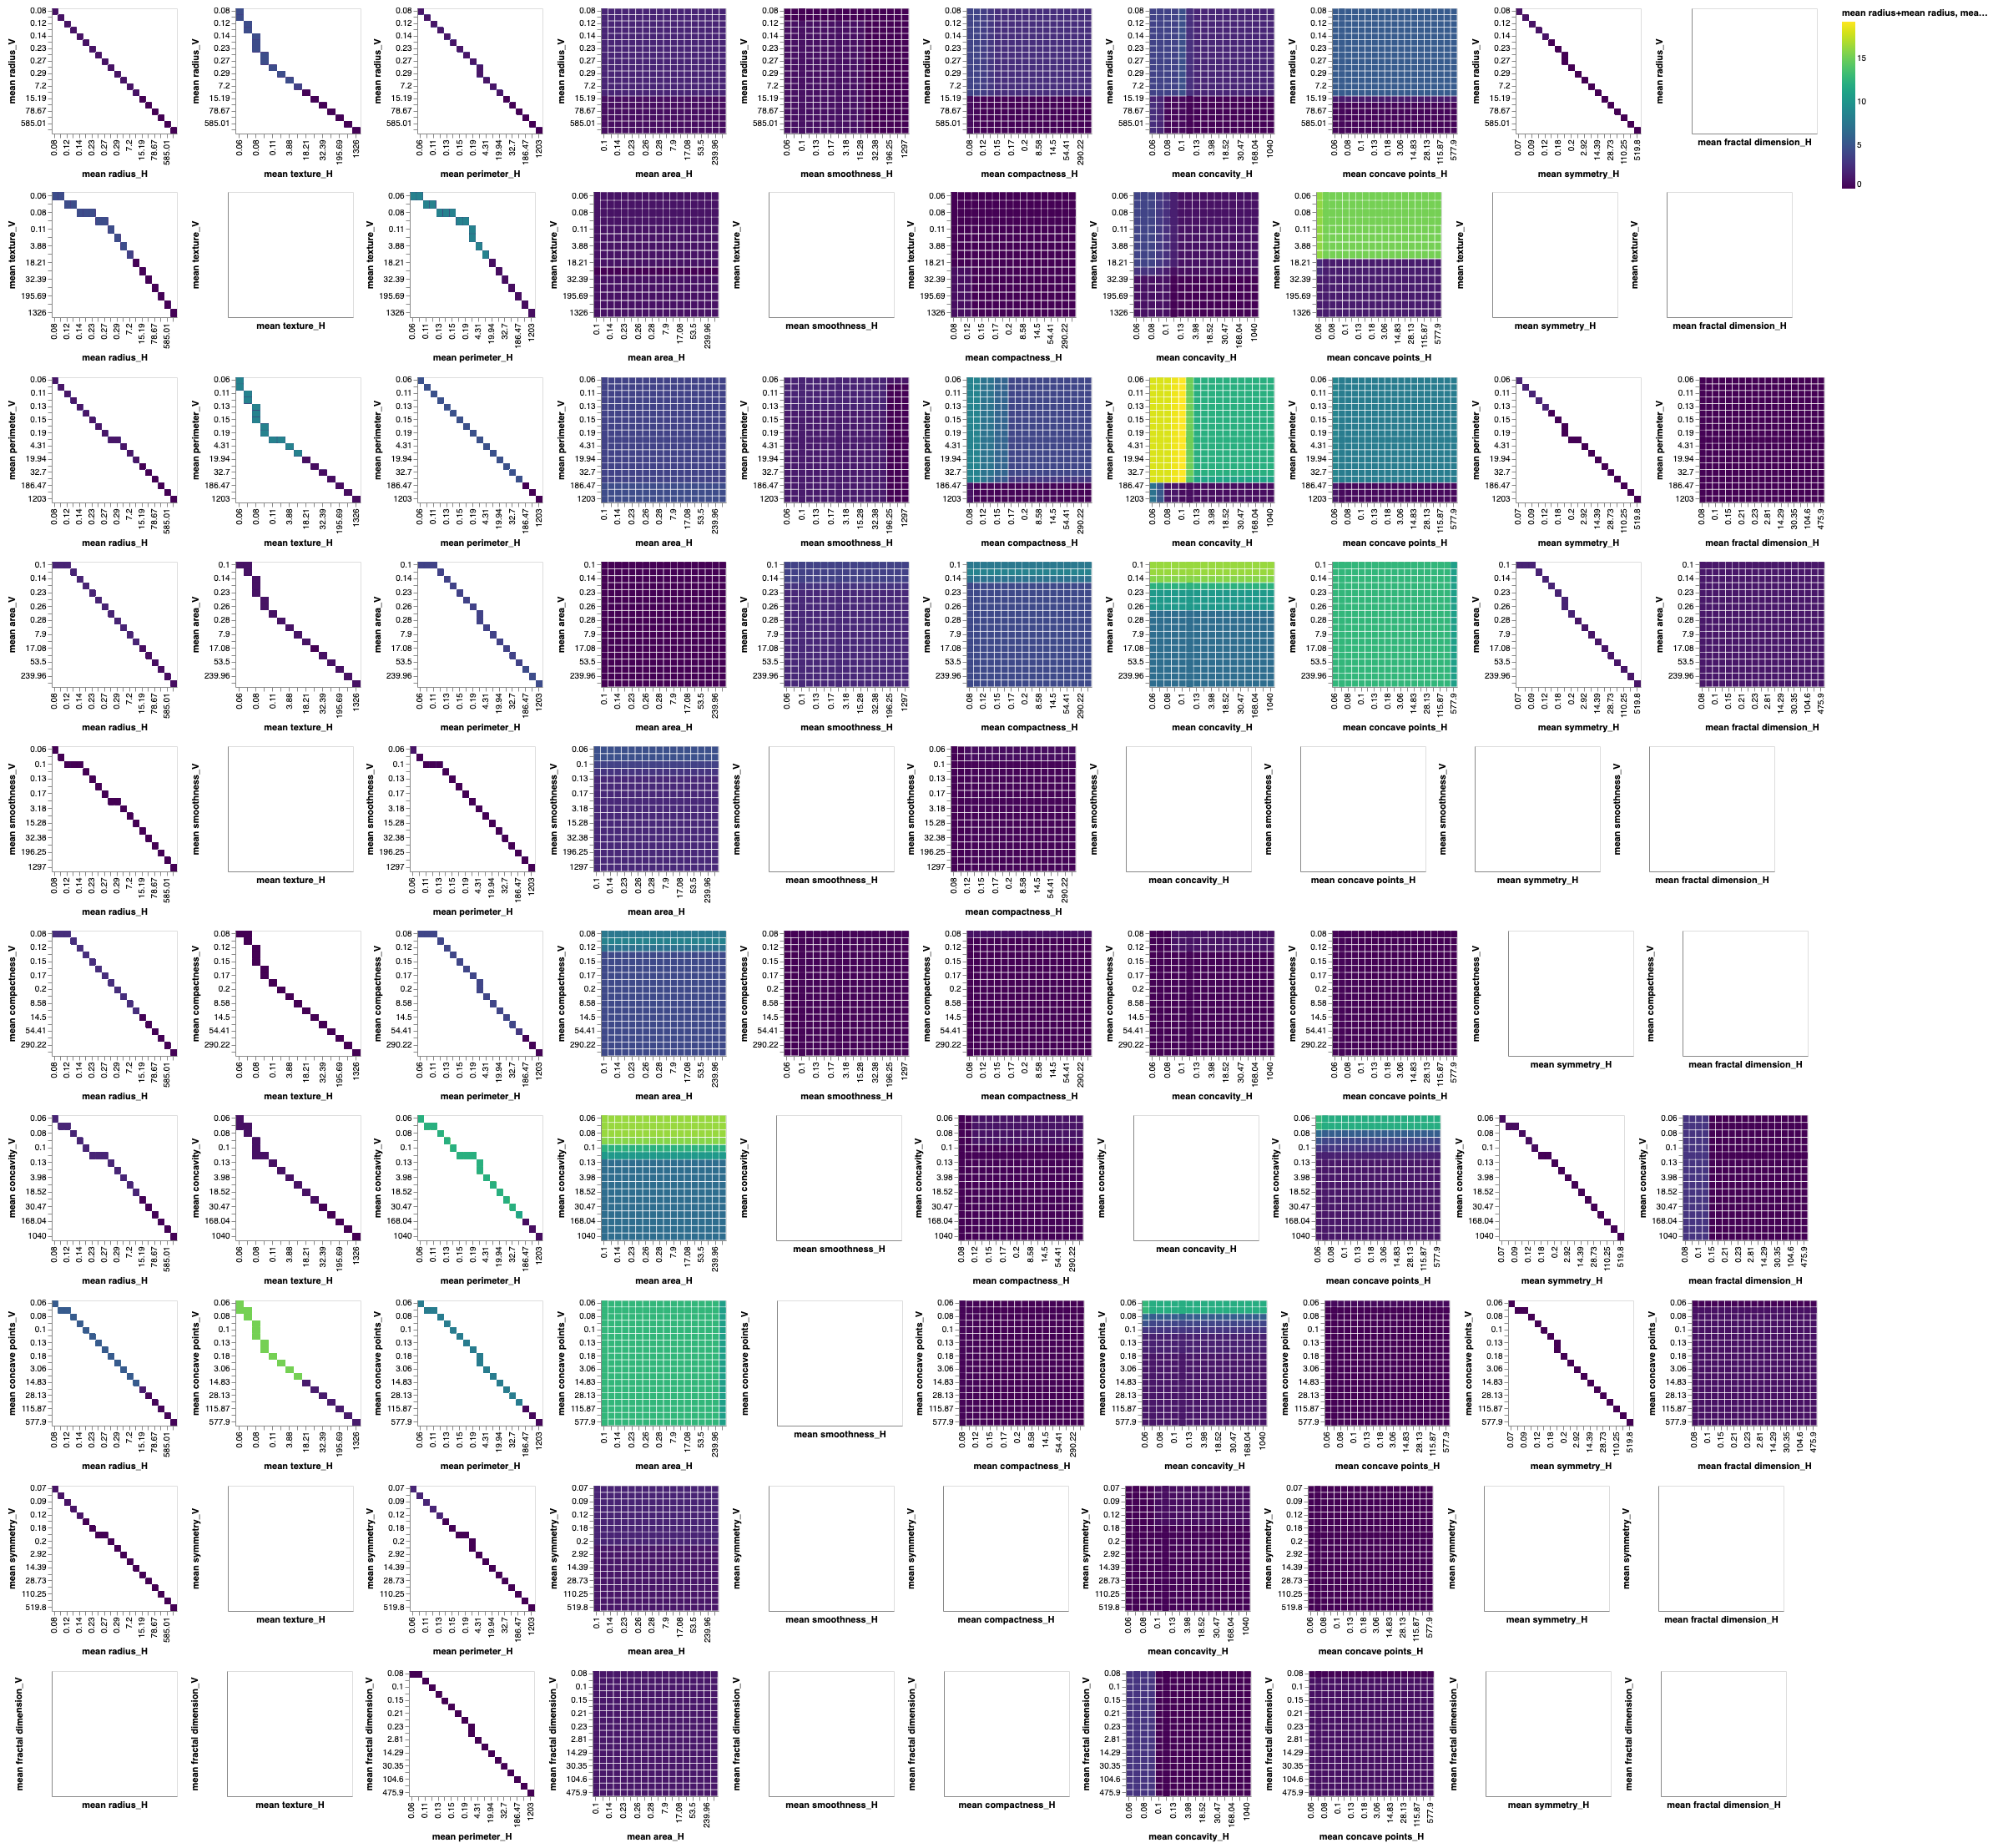

In [193]:
base = alt.Chart().mark_rect().encode(
).properties(
    width=150,
    height=150
).interactive()

chart = alt.vconcat(data=chart_data)
for y_feature in data_to_use["feature_names"]:
    row = alt.hconcat()
    for x_feature in data_to_use["feature_names"]:
        x_encoding = x_feature+"_H:O"
        y_encoding = y_feature+"_V:O"
        temp_sort = sorted([x_feature, y_feature])
        color_encoding = "alt.Color(field=\"" + temp_sort[0] + "+" + temp_sort[1]\
        + "\", type=\"quantitative\", scale=alt.Scale(scheme=\"greenblue\"))"
        color_encoding = temp_sort[0] + "+" + temp_sort[1] +":Q"
        row |= base.encode(x=x_encoding, y=y_encoding, color=color_encoding)
    chart &= row
chart